In [10]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [11]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [12]:
steamDF = []
airDF = []
liquidDF = []
airLiqDF = []

steamDF = filter(:Service => ==("steam"), valveData)
airDF = filter(:Service => ==("air"), valveData)
liquidDF = filter(:Service => ==("liquid"), valveData)
airLiqDF = filter(:Service => ==("air/liquid"), valveData)
naDF = filter(:Service => ==("na"), valveData)

n_steam = 0
n_air = 0
n_liquid = 0
n_airLiq = 0
n_na = 0

steamVend = (collect(steamDF[:,1]))
for i in 1:length(steamVend)
    n_steam = steamDF[i,2] +n_steam
end

airVend = (collect(airDF[:,1]))
for i in 1:length(airVend)
    n_air = airDF[i,2] +n_air
end

liquidVend = (collect(liquidDF[:,1]))
for i in 1:length(liquidVend)
    n_liquid = liquidDF[i,2] +n_liquid
end

airLiqVend = (collect(airLiqDF[:,1]))
for i in 1:length(airLiqVend)
    n_airLiq = airLiqDF[i,2] +n_airLiq
end

naVend = (collect(naDF[:,1]))
for i in 1:length(naVend)
    n_na = naDF[i,2]+n_na
end

steamDF

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,c,85,1,1,13.00%,9.70%,175,steam
3,g,41,5,2,6.70%,3.30%,165,steam
4,z,40,6,1,24.00%,20.00%,165,steam
5,k,1,0,0,0.00%,0.00%,missing,steam
6,m,14,7,3,10.00%,3.00%,80,steam


Set Up Model

In [13]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
        μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
        σ ~ Exponential(1) #allow possibility of large std dev in data
    
        μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ) #assume that the logit(probability) is distributed normally for each vendor
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i] #number of trials for binomial function
        p = logistic(μ[i]) #force p (probability of failure) to be 0<p<1
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p) #binomial distribution used (most appropriate since measuring probability of failure given trial data)
    end
end

valveTesting (generic function with 2 methods)

In [14]:
steam_model = valveTesting(steamDF[:,1], steamDF[:,2], steamDF[:,3])

steam_posterior = sample(steam_model, NUTS(), 1000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\flemm\.julia\packages\Turing\oFGEb\src\mcmc\hmc.jl:213
Sampling   0%|█                                         |  ETA: 0:04:37
Sampling   1%|█                                         |  ETA: 0:02:22
Sampling   1%|█                                         |  ETA: 0:01:34
Sampling   2%|█                                         |  ETA: 0:01:10
Sampling   2%|█                                         |  ETA: 0:00:56
Sampling   3%|██                                        |  ETA: 0:00:47
Sampling   3%|██                                        |  ETA: 0:00:40
Sampling   4%|██                                        |  ETA: 0:00:35
Sampling   4%|██                                        |  ETA: 0:00:31
Sampling   5%|██                                        |  ETA: 0:00:28
Sampling   5%|███                                       |  ETA: 0:00:26
Sampling   

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.88 seconds
Compute duration  = 2.88 seconds
parameters        = μ_bar, σ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

       μ_bar   -2.0039    0.6330    0.0248    687.4320   600.9303    1.0058    ⋯
           σ    1.4262    0.5898    0.0293    398.7832   334.1200    0.9995    ⋯
        μ[1]   -1.5903    0.8052    0.0233   1237.8363   686.5418    0.9999    ⋯
        μ[2]   -3.8389    0.7656    0.0307    647.9869   583.2867    0.9992    ⋯
        μ[3]   -2.0370    0.48

In [15]:
steam_postDF = DataFrame(steam_posterior)



Row,iteration,chain,μ_bar,σ,μ[1],μ[2],μ[3],μ[4],μ[5],μ[6],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,-3.09188,1.12649,-1.70287,-3.68001,-1.87009,-1.28322,-1.2641,-0.14305,-25.0674,7.0,1.0,0.972523,-25.0674,28.4403,-0.0172636,-0.562649,3.0,0.0,0.571105,0.571105
2,502,1,-1.97899,1.13665,-1.13589,-3.99008,-1.99342,-1.34431,-1.41736,-0.332598,-20.1922,7.0,1.0,1.0,-20.1922,26.1056,-1.57114,-1.57114,3.0,0.0,0.571105,0.571105
3,503,1,-2.36191,0.63833,-2.02095,-3.03769,-2.00497,-2.26179,-2.02878,-0.713027,-20.6438,7.0,1.0,0.850812,-20.6438,22.7327,0.0922343,0.765502,3.0,0.0,0.571105,0.571105
4,504,1,-2.52104,0.78882,-3.06852,-3.42665,-1.98139,-1.87459,-3.28389,-0.259757,-22.6628,3.0,1.0,0.541218,-22.6628,28.4712,0.399985,0.768372,2.0,0.0,0.571105,0.571105
5,505,1,-1.14338,2.42978,0.518672,-3.56432,-1.98594,-1.66304,-0.697679,-0.573282,-26.6613,7.0,1.0,0.508679,-26.6613,33.6305,0.734964,1.00586,3.0,0.0,0.571105,0.571105
6,506,1,-2.05677,2.39398,-3.5237,-7.37156,-2.00943,-1.69664,-1.71967,0.460507,-29.3446,7.0,1.0,0.840604,-29.3446,34.9418,0.105418,0.38626,3.0,0.0,0.571105,0.571105
7,507,1,-4.63522,2.06959,-0.665449,-6.40245,-2.66534,-2.61593,-4.93015,-0.550541,-30.3808,7.0,1.0,0.942271,-30.3808,35.9148,-0.017382,0.314556,3.0,0.0,0.571105,0.571105
8,508,1,-0.756898,2.18415,-2.05722,-5.38923,-2.18422,-1.24863,-2.70538,0.121834,-25.3423,7.0,1.0,0.992415,-25.3423,33.1798,-0.127388,-0.237587,3.0,0.0,0.571105,0.571105
9,509,1,-2.10819,1.06018,-1.64619,-2.72048,-1.83431,-2.46138,-2.43219,-0.725247,-21.872,7.0,1.0,0.946776,-21.872,26.353,-0.530834,-0.530834,3.0,0.0,0.571105,0.571105


Vendor 1 Check (USED FOR DEBUGGING)

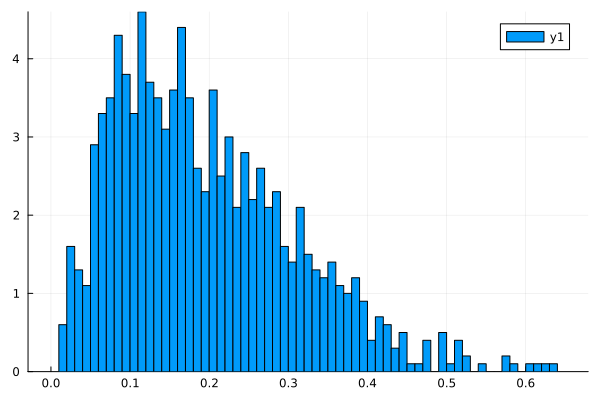

In [16]:
vend1_processed = zeros(nrow(steam_postDF))

for i in 1:nrow(steam_postDF)
    vend1_processed[i] = logistic(steam_postDF[i,5]) #recover probability of a valve from this vendor & service medium failing an initial pop test
end

histogram(vend1_processed, normalize=:pdf, bins=101)

Process Steam Medium Data

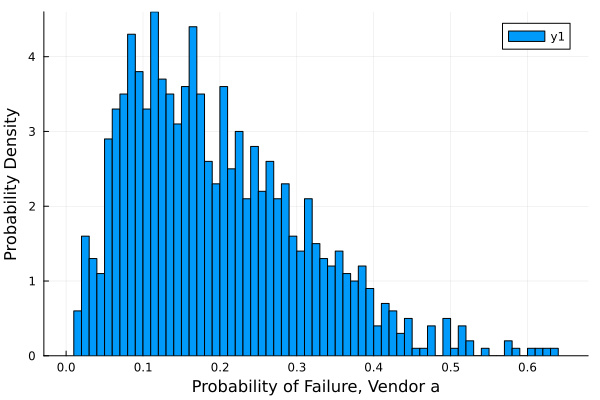

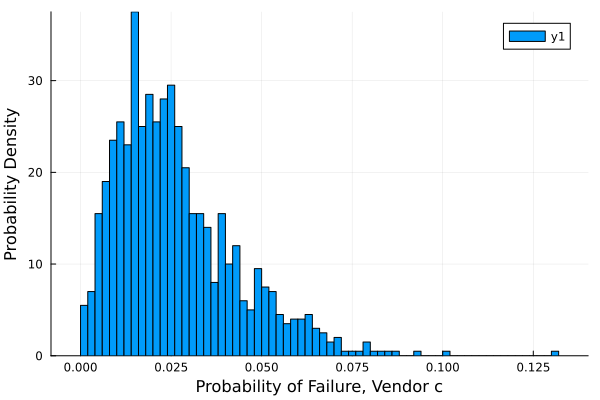

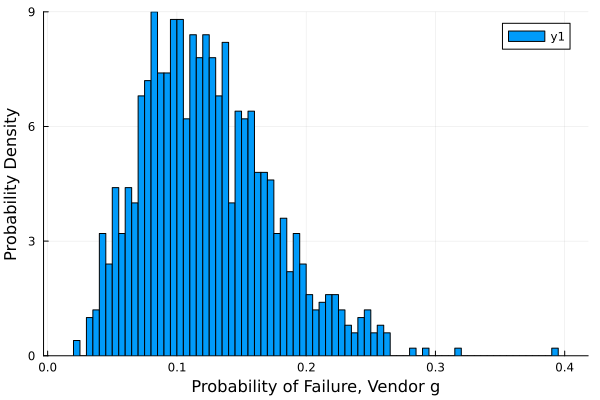

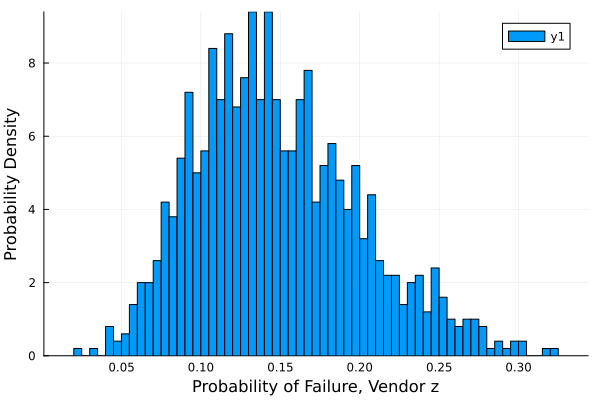

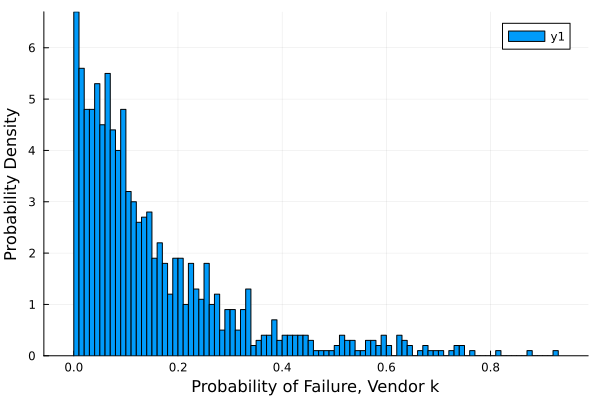

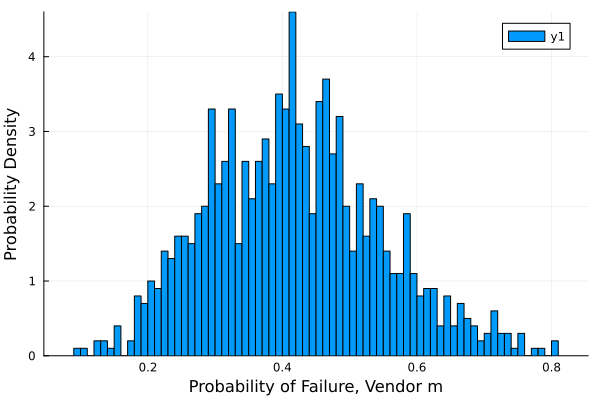

In [17]:
#gather all posterior data into an array, with each column representing a vendor's data
#also make an array of plots for each
steam_processed = zeros(nrow(steam_postDF), nrow(steamDF))
steam_plots = Array{Plots.Plot{Plots.GRBackend},1}()

#set array values to match calculated μ values from MCMC
#post-process with logistic function to recover probability of valve failure
for i in 1:nrow(steamDF)
    for j in 1:nrow(steam_postDF)
        steam_processed[j,i] = logistic(steam_postDF[j, "μ[$i]"])
    end
    #plotter is an intermediate value to gather plot data & incorporate into plot array
    plotter = histogram(steam_processed[:,i], xlab = "Probability of Failure, Vendor " * steamDF[i, 1], ylab = "Probability Density", normalize=:pdf, bins=101)
    push!(steam_plots, plotter)
end
#plot all probability plots for the steam medium, grouped by vendor
for z in 1:length(steam_plots)
    display(plot(steam_plots[z]))
end

Predict Valve Failure for Steam Based on Model

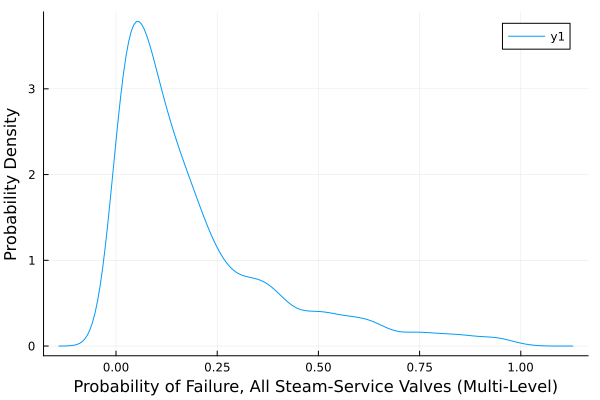

In [ ]:
steam_logodds = rand.(Normal.(steam_postDF.μ_bar[1:1000], steam_postDF.σ[1:1000]))
steam_pdf = logistic.(steam_logodds)

predict_plot = plot(xlab="Probability of Failure, All Steam-Service Valves (Multi-Level)", ylab="Probability Density")
density!(steam_pdf)